In [ ]:
#Necessary Library
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import re
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## Data Preparing

In [ ]:
def import_data(file):
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    return df

In [ ]:
## Main Data
application_train = import_data("/drive/My Drive/home-credit-default-risk/application_train.csv")
application_test = import_data("/drive/My Drive/home-credit-default-risk/application_test.csv")

In [ ]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


## Date Anchoring - Bureau Data

In [ ]:
bureau_data = import_data("/drive/My Drive/home-credit-default-risk/bureau.csv")

In [ ]:
# Setting anchor date of the start of home credit application start as a proxy date
start_date = pd.to_datetime('2018-05-18')

In [ ]:
# Subtract days and create a new column with the resulting date + 30 days tenure
bureau_data['NewDate'] = start_date + pd.to_timedelta(bureau_data['DAYS_CREDIT'], unit='D')

In [ ]:
# Add 30 days tenure to the NewDate column
bureau_data['NewDatePlus30'] = bureau_data['NewDate'] + pd.to_timedelta(30, unit='D')

In [ ]:
# Extract month and year in the desired format
bureau_data['timestamp'] = bureau_data['NewDatePlus30'].dt.strftime('%B %Y')

In [ ]:
# Selecting columns
bureau_data = bureau_data[['SK_ID_CURR','timestamp']]

In [ ]:
bureau_data = bureau_data.drop_duplicates(subset=['SK_ID_CURR'],keep='last')

## MEV Processing

In [ ]:
mev_data = import_data("/drive/My Drive/home-credit-default-risk/MEV Data.csv")

In [ ]:
# Interpolate to fill NaN values in all columns using polynomial interpolation
mev_data = mev_data.apply(lambda col: col.interpolate() if col.isnull().any() else col)

In [ ]:
# Fill the rest of null value
mev_data = mev_data.fillna(method='bfill')
mev_data = mev_data.drop(columns={'Periode'})

In [ ]:
# Join with bureau
bureau_data = bureau_data.merge(mev_data,on=['timestamp'],how='left')
bureau_data.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SK_ID_CURR           305811 non-null  int64  
 1   timestamp            305811 non-null  object 
 2   Inflation Rate       305811 non-null  float64
 3   BI 7 Days            305811 non-null  float64
 4   Interest Rate        305811 non-null  float64
 5   Unemployment Rate    305811 non-null  float64
 6   Exchange Rate USD    305811 non-null  object 
 7   Consumer Credit      305811 non-null  float64
 8   GDP Growth           305811 non-null  float64
 9   CPI                  305811 non-null  float64
 10  Business Confidence  305811 non-null  float64
 11  Gasoline Price       305811 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 28.0+ MB


In [ ]:
# Selecting columns
bureau_data = bureau_data.drop(columns={'timestamp'})

In [ ]:
# Formatting
bureau_data['Exchange Rate USD'] = bureau_data['Exchange Rate USD'].str.replace(',', '').astype(int)

In [ ]:
# Join with application data
application_train = application_train.merge(bureau_data,on='SK_ID_CURR',how='left')
application_test = application_test.merge(bureau_data,on='SK_ID_CURR',how='left')

## Credit Processing

In [ ]:
application_train = application_train[application_train['AMT_INCOME_TOTAL'] != 1.170000e+08]
application_train = application_train[application_train['AMT_REQ_CREDIT_BUREAU_QRT'] != 261]
application_train = application_train[application_train['OBS_30_CNT_SOCIAL_CIRCLE'] < 300]
application_train['DAYS_EMPLOYED'] = (application_train['DAYS_EMPLOYED'].apply(lambda x: x if x != 365243 else np.nan))

In [ ]:
def cat_to_dummy(train, test):
    train_d = pd.get_dummies(train, drop_first=False)
    test_d = pd.get_dummies(test, drop_first=False)
    # make sure that the number of features in train and test should be same
    for i in train_d.columns:
        if i not in test_d.columns:
            if i!='TARGET':
                train_d = train_d.drop(i, axis=1)
    for j in test_d.columns:
        if j not in train_d.columns:
            if j!='TARGET':
                test_d = test_d.drop(i, axis=1)
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(train.memory_usage().sum() / 1024**2,train_d.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(test.memory_usage().sum() / 1024**2,test_d.memory_usage().sum() / 1024**2))
    return train_d, test_d

In [ ]:
application_train_ohe, application_test_ohe = cat_to_dummy(application_train, application_test)

Memory usage of train increases from 311.00 to 313.63 MB
Memory usage of test increases from 48.72 to 49.14 MB


In [ ]:
application_train_ohe = application_train_ohe.set_index('SK_ID_CURR')
application_test_ohe = application_test_ohe.set_index('SK_ID_CURR')

In [ ]:
application_train_ohe = application_train_ohe.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
application_test_ohe = application_test_ohe.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
X_rus, y_rus = (application_train_ohe.drop(['TARGET'], axis=1),application_train_ohe['TARGET'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=314, stratify=y_rus)

In [ ]:
import lightgbm as lgb
fit_params={'callbacks':[lgb.early_stopping(stopping_rounds=30)], "eval_metric" : 'auc', "eval_set" : [(X_test,y_test)],'eval_names': ['valid']}

In [ ]:
positive_samples = 19830
negative_samples = 225359

x = negative_samples/positive_samples
y = np.sqrt(negative_samples/positive_samples)

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50),
             'min_child_samples': sp_randint(100, 500),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8),
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight':[1,x,y]}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(estimator=clf, param_distributions=param_test, n_iter=100,scoring='roc_auc',cv=3,refit=True,random_state=314,verbose=True)

In [ ]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
opt_parameter = {'colsample_bytree': 0.8072453835765078, 'min_child_samples': 468, 'min_child_weight': 0.1, 'num_leaves': 6,
                 'reg_alpha': 50, 'reg_lambda': 10, 'scale_pos_weight': 3.3711346255587222, 'subsample': 0.6035220447746761}

In [ ]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameter)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params)

[LightGBM] [Info] Number of positive: 19830, number of negative: 225359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12188
[LightGBM] [Info] Number of data points in the train set: 245189, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080876 -> initscore=-2.430499
[LightGBM] [Info] Start training from score -2.430499
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[728]	valid's auc: 0.764573


LGBMClassifier(colsample_bytree=0.8072453835765078, metric='None',
               min_child_samples=468, min_child_weight=0.1, n_estimators=5000,
               n_jobs=4, num_leaves=6, random_state=314, reg_alpha=50,
               reg_lambda=10, scale_pos_weight=3.3711346255587222,
               subsample=0.6035220447746761)

<Axes: >

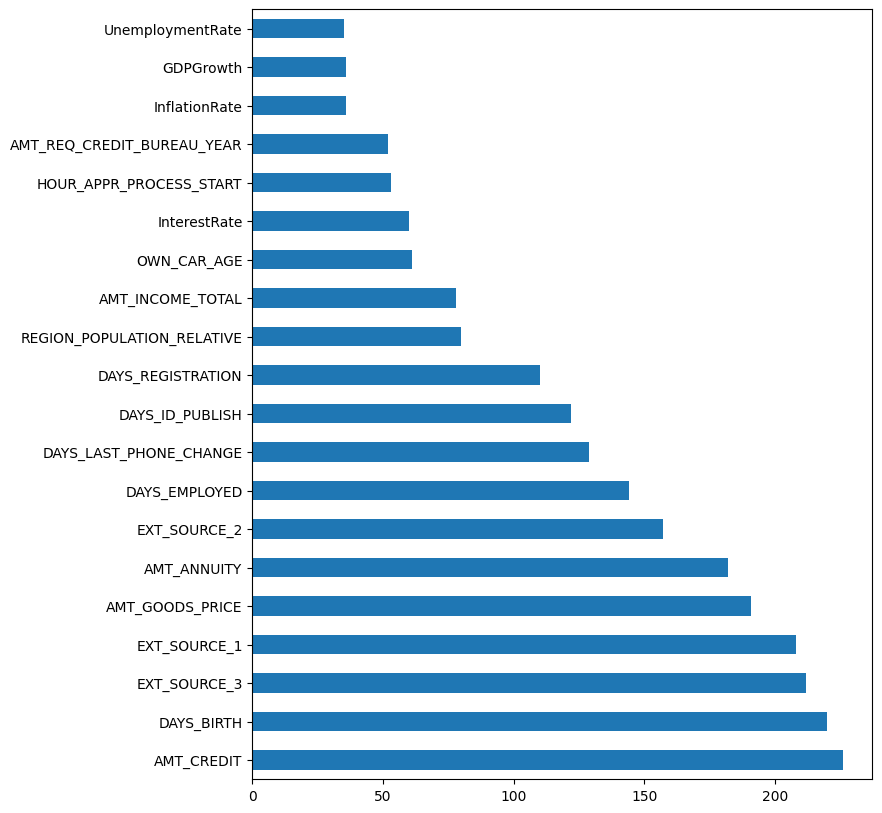

In [ ]:
feat_imp = pd.Series(clf_final.feature_importances_, index=application_train_ohe.drop(['TARGET'], axis=1).columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

In [ ]:
X_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terracedhouse,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
396875,0,67500.0,436032.0,21339.0,360000.0,0.008068,-20951,NaN,-4220.0,-3563,...,False,False,False,False,False,False,False,False,False,False
416211,0,90000.0,247500.0,13950.0,247500.0,0.028663,-17806,-993.0,-10040.0,-1344,...,False,False,False,False,False,False,False,False,False,False
251674,0,108000.0,344043.0,12879.0,297000.0,0.020246,-21125,NaN,-12167.0,-4029,...,False,False,False,False,False,False,False,False,False,False
421574,1,202500.0,450000.0,21109.5,450000.0,0.006296,-11052,-1214.0,-4826.0,-2499,...,False,False,False,False,False,False,False,False,False,False
241698,0,180000.0,1372500.0,36202.5,1372500.0,0.007120,-22656,NaN,-13628.0,-4300,...,False,False,False,False,False,False,True,False,True,False


In [ ]:
probabilities_train = clf_final.predict_proba(X_train)[:,1]
probabilities_test = clf_final.predict_proba(X_test)[:,1]
X_train['proba_default'] = probabilities_train
X_train['default_flag'] = y_train
X_test['proba_default'] = probabilities_test
X_test['default_flag'] = y_test

In [ ]:
def plot_auc(ax, ttl, y_train=[], y_train_pred=[], y_test=[], y_test_pred=[]):

    if ((len(y_train)>0)&(len(y_train_pred)>0)):
        fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
        roc_auc_train = auc(fpr_train, tpr_train)
        ax.plot(fpr_train, tpr_train)

    if ((len(y_test)>0)&(len(y_test_pred)>0)):
        fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
        roc_auc_test = auc(fpr_test, tpr_test)
        ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve {0}'.format(ttl))

    train_text = None
    test_text = None
    if ((len(y_train)>0)&(len(y_train_pred)>0)):
        train_text = 'TRAIN auc = {:.2f}'.format(roc_auc_train)
    if ((len(y_test)>0)&(len(y_test_pred)>0)):
        test_text = 'TEST  auc = {:.2f}'.format(roc_auc_test)
    leg = []
    if ((len(y_train)>0)&(len(y_train_pred)>0)):
        leg.append(train_text)
    if ((len(y_test)>0)&(len(y_test_pred)>0)):
        leg.append(test_text)
    ax.legend(leg)

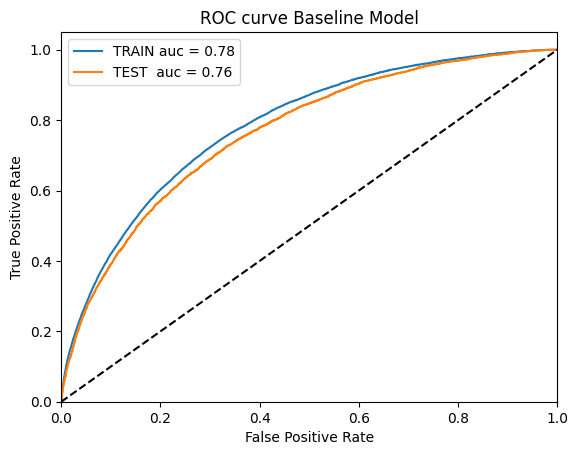

In [ ]:
fig,ax = plt.subplots(1)
plot_auc(ax, ttl = "Baseline Model",y_train=X_train.default_flag, y_train_pred=X_train.proba_default,y_test=X_test.default_flag, y_test_pred=X_test.proba_default)

In [ ]:
X_train.to_pickle('/drive/My Drive/home-credit-default-risk/fekdi_train_using_MEV.pkl')
X_test.to_pickle('/drive/My Drive/home-credit-default-risk/fekdi_test_using_MEV.pkl')